In [31]:
from tensorflow.keras import layers, models, Input
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, accuracy_score

In [18]:
IMAGE_SIZE = 224
BATCH_SIZE = 64
EPOCH_NUM = 20

In [19]:
# ==== Image branch ==== #
image_input = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="image_input")
base_model = DenseNet121(include_top=False, weights="imagenet", input_tensor=image_input)
x = layers.GlobalAveragePooling2D()(base_model.output)

In [20]:
# ==== Clinical branch ==== #
clinical_input = Input(shape=(5,), name='clinical_input')
y = layers.Dense(32, activation='relu')(clinical_input)
y = layers.Dropout(0.3)(y)

In [21]:
# ==== Fusion ==== #
combined = layers.Concatenate()([x,y])
z = layers.Dense(64, activation='relu')(combined)
z = layers.Dropout(0.3)(z)
output = layers.Dense(1, activation='sigmoid')(z)

In [22]:
# ==== Model ==== #
model = models.Model(inputs=[image_input, clinical_input], outputs=output)
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

Data Preprocess

In [1]:
from sklearn.model_selection import train_test_split
from PIL import Image
import pandas as pd
import os
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder

In [2]:
df = pd.read_csv('../data/Subset-Chexchonet/prototype.csv')
le = LabelEncoder()
df["sex"] = le.fit_transform(df["sex"]).astype(np.float32)
df['cxr_path'] = '../data/Subset-Chexchonet/images/' + df['cxr_filename']


In [3]:
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["composite_slvh_dlv"], random_state=42)
train_df, val_df  = train_test_split(train_df, test_size=0.1, stratify=train_df["composite_slvh_dlv"], random_state=42)

In [11]:
def read_images(data_df, img_size=(224, 224)):
    images = []
    for _, row in data_df.iterrows():
        image_path = row['cxr_path']
        img = Image.open(image_path).convert("RGB")  # đảm bảo 3 kênh
        img = img.resize((IMAGE_SIZE, IMAGE_SIZE))
        img = np.array(img) / 255.0  # chuẩn hóa về [0,1]
        images.append(img)
    return np.array(images, dtype=np.float32)


In [12]:
train_images = read_images(train_df)

In [13]:
test_images = read_images(test_df)
val_images = read_images(val_df)

In [ ]:
clinical_cols = ["age", "sex", "ivsd", "lvpwd", "lvidd"]
train_clinical = train_df[clinical_cols].values.astype(np.float32)
val_clinical   = val_df[clinical_cols].values.astype(np.float32)
test_clinical  = test_df[clinical_cols].values.astype(np.float32)

In [15]:
# Tạo dataset
train_ds = tf.data.Dataset.from_tensor_slices(((train_images, train_clinical), train_df["composite_slvh_dlv"].values))
val_ds   = tf.data.Dataset.from_tensor_slices(((val_images, val_clinical), val_df["composite_slvh_dlv"].values))
test_ds  = tf.data.Dataset.from_tensor_slices(((test_images, test_clinical), test_df["composite_slvh_dlv"].values))

# Shuffle + batch
train_ds = train_ds.shuffle(512).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds   = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds  = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [ ]:
earlystop =  EarlyStopping(monitor='val_auc', patience=3, restore_best_weights=True, verbose=1, mode="max")
checkpoint = ModelCheckpoint('../multimodal_best_model.keras', monitor='val_loss', save_best_only=True, verbose=True)

In [29]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCH_NUM,
    callbacks=[earlystop, checkpoint],
    batch_size=BATCH_SIZE,
    verbose=True
)


Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6063 - loss: 0.8644
Epoch 1: val_loss improved from inf to 1.26892, saving model to ../best_model.keras


c:\Users\Phi Yen\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_auc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 148s 6s/step - accuracy: 0.6053 - loss: 0.8638 - val_accuracy: 0.5000 - val_loss: 1.2689
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6103 - loss: 0.6721
Epoch 2: val_loss improved from 1.26892 to 0.69114, saving model to ../best_model.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 145s 6s/step - accuracy: 0.6116 - loss: 0.6711 - val_accuracy: 0.5188 - val_loss: 0.6911
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7325 - loss: 0.5620
Epoch 3: val_loss improved from 0.69114 to 0.68136, saving model to ../best_model.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 146s 6s/step - accuracy: 0.7318 - loss: 0.5621 - val_accuracy: 0.5562 - val_loss: 0.6814
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7557 - loss: 0.4897
Epoch 4: val_loss did not improve from 0.68136
23/23 ━━━━━━━━━━━━━━━━━━━━ 152s 7s/step - accuracy: 0.7556 - loss: 0.4906 - val_accuracy: 0.5188 - val_loss: 0.7473
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8

In [46]:
y_val_pred = model.predict(val_ds)
y_val_true = val_df['composite_slvh_dlv'].values
y_val_pred = model.predict(val_ds)
y_val_true = val_df['composite_slvh_dlv'].values  

#  Tìm threshold tối ưu (theo ROC)
fpr, tpr, thresholds = roc_curve(y_val_true, y_val_pred)
youden_idx = np.argmax(tpr - fpr)   # maximize sensitivity+specificity
best_thresh = thresholds[youden_idx]
print("Best threshold (ROC):", best_thresh)

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 975ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 945ms/step
Best threshold (ROC): 0.99982184


In [34]:
y_pred = model.predict(test_ds).ravel() 
y_true = test_df['composite_slvh_dlv'].values

7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step


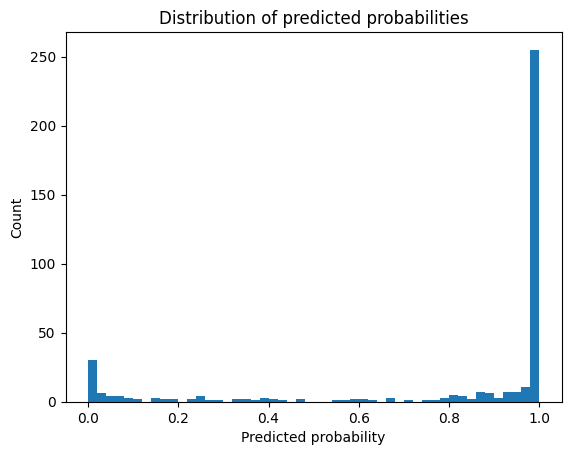

In [35]:
import matplotlib.pyplot as plt

plt.hist(y_pred, bins=50)
plt.xlabel("Predicted probability")
plt.ylabel("Count")
plt.title("Distribution of predicted probabilities")
plt.show()

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

Test AUC: 69.16%
Test Accuracy: 63.75%


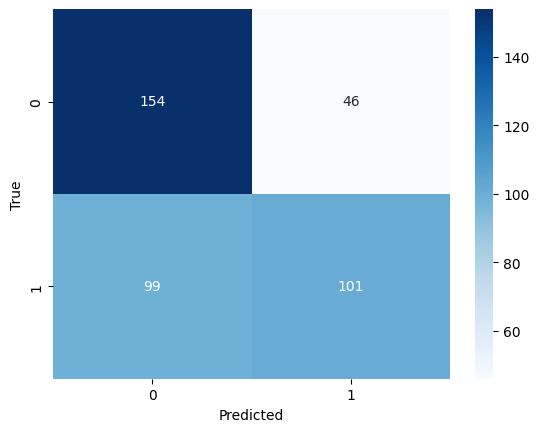

In [47]:
# ACC & ROC & AUC
auc = roc_auc_score(y_true, y_pred)
print(f"Test AUC: {auc*100:.2f}%")

# Confusion Matrix
y_pred_class = (y_pred > best_thresh).astype(int)
acc = accuracy_score(y_true, y_pred_class)
print(f"Test Accuracy: {acc*100:.2f}%")
cm = confusion_matrix(y_true, y_pred_class)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()